In [26]:
import os
import shutil
import random
import librosa
import librosa.display
from pydub import AudioSegment
import IPython
from scipy.io import wavfile
import noisereduce as nr
from scipy import signal
import time
import soundfile as sf
from datetime import timedelta as td

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import graphviz
from xgboost import plot_tree
import pickle

In [2]:
def convert_wav(file_path,main_dir):
    wav_file=""
    file_name=os.path.basename(file_path)
    wav_dir=main_dir+"\\VoxCeleb_gender\\wav_files\\"
    if(file_path.endswith(".m4a")):
        audio = AudioSegment.from_file(file_path, format="m4a")
        wav_file = wav_dir+file_name.split(".")[0] + ".wav"
        audio.export(wav_file, format="wav")
    elif(file_path.endswith(".mp4")):
        audio = AudioSegment.from_file(file_path, format="mp4")
        wav_file= wav_dir+file_name.split(".")[0] + ".wav"
        audio.export(wav_file, format="wav")
    elif(file_path.endswith(".mp3")):
        audio = AudioSegment.from_file(file_path, format="mp3")
        wav_file = wav_dir+file_name.split(".")[0] + ".wav"
        audio.export(wav_file, format="wav")
    elif(file_path.endswith(".wav")):
        wav_file=wav_dir+file_name
    return wav_file

In [3]:
def noise_reduce(file_path, main_dir):
    rate, data = wavfile.read(file_path)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    file_name=os.path.basename(file_path)
    noise_reduced_dir=main_dir+"\\VoxCeleb_gender\\noise_reduced_mix\\"
    wavfile.write(noise_reduced_dir+ file_name, rate, reduced_noise)
    return  noise_reduced_dir+ file_name


In [4]:
def extract_mfcc(file):
    y, sr= librosa.load(file)
    feature_arr=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    scaled_feature_arr = np.mean(feature_arr.T, axis=0)
    return scaled_feature_arr

In [5]:
os.chdir("C:\\Users\\Arun\\OneDrive\\Desktop\\CSE\\gender_classifier\\")
main_dir=os.getcwd()
source_folder = main_dir+ "\\VoxCeleb_gender\\males\\"
destination_folder = main_dir+"\\VoxCeleb_gender\\mixed\\"
for file_name in os.listdir(source_folder):
    source = source_folder + file_name
    destination = destination_folder + file_name
    if os.path.isfile(source):
        shutil.copy(source, destination)

source_folder = main_dir+"\\VoxCeleb_gender\\females\\"
destination_folder = main_dir+"\\VoxCeleb_gender\\mixed\\"
for file_name in os.listdir(source_folder):
    source = source_folder + file_name
    destination = destination_folder + file_name
    if os.path.isfile(source):
        shutil.copy(source, destination)


dir_list=os.listdir(destination_folder)
mixed_dir=random.sample(dir_list, len(dir_list))
os.chdir(destination_folder)
audio_df=pd.DataFrame() 
filepath_arr=[] 
index_arr=[]
index_var=0
for file in mixed_dir:
    wav_file=convert_wav(file,main_dir)
    noise_reduced_file=noise_reduce(wav_file, main_dir)
    filepath_arr.append(noise_reduced_file)
    scaled_feature_array=extract_mfcc(noise_reduced_file)
    features_df=pd.DataFrame(data=scaled_feature_array)
    features_df=features_df.transpose()
    audio_df=pd.concat([audio_df, features_df], axis=0)
    index_arr.append(index_var)
    index_var=index_var+1


audio_df=audio_df.set_index(pd.Index(index_arr))
final_df=audio_df.copy()
final_df["file path"]=filepath_arr

In [6]:
gender_arr=[""] * 2000
for i in final_df.index:
    path=final_df["file path"][i]
    file_name = os.path.basename(path)
    file = os.path.splitext(file_name)[0]
    male_dir=main_dir+"\\VoxCeleb_gender\\males\\"
    for files in os.listdir(male_dir):
        if (file in files):
           gender_arr[i]="MALE"
    female_dir=main_dir+"\\VoxCeleb_gender\\females\\"
    for files in os.listdir(female_dir):
        if (file in files):
           gender_arr[i]="FEMALE"
final_df["Gender"]=gender_arr
final_df.to_excel(main_dir+"\\VoxCeleb_gender\\audio_dataset.xlsx")

In [16]:
X= final_df.iloc[0:2001, 0:40]
y=final_df.iloc[0:2001, 41:42]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [8]:
# st_x= StandardScaler()
# X_train= st_x.fit_transform(X_train)
# pca = PCA(n_components = 10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_
# print(explained_variance)

[0.19589338 0.13663904 0.09555815 0.06133851 0.04927342 0.04399017
 0.0395812  0.03401941 0.03288274 0.02677237]


In [17]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.805


c:\Users\Arun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test, y_pred))
print(cm)

C:\Users\Arun\AppData\Local\Temp\ipykernel_23064\630988046.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8725
[[175  16]
 [ 35 174]]


In [19]:
model = XGBClassifier()
ord_enc = OrdinalEncoder()
y_trainxgb=ord_enc.fit_transform(y_train)
y_testxgb=ord_enc.fit_transform(y_test)
model.fit(X_train, y_trainxgb)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_testxgb, y_pred))


0.885


In [40]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
filename ="svm_model.sav"
pickle.dump(clf, open(filename, 'wb'))
y_pred = clf.predict(X_test)
clf.support_vectors_
cm = confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test, y_pred))
print(cm)

c:\Users\Arun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9025
[[172  19]
 [ 20 189]]


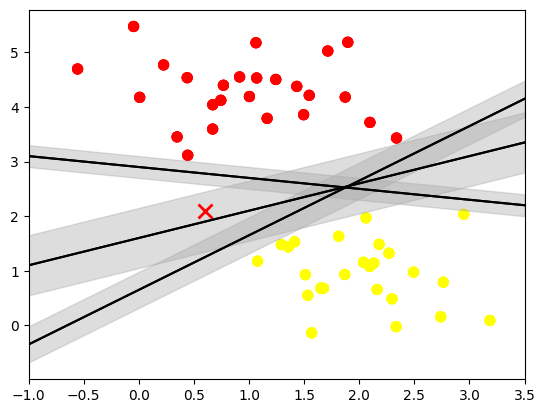

In [21]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

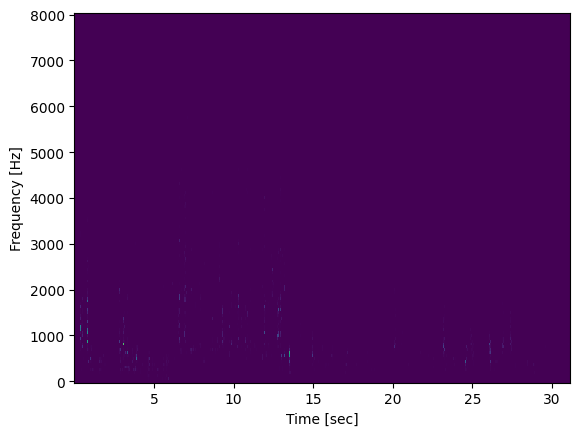

In [14]:
path_arr=(final_df.iloc[0:51,40:41]).to_numpy()
for file_path in path_arr:
    file_name=os.path.basename(file_path[0])
    audio_images_dir=main_dir+"\\VoxCeleb_gender\\audio_spectograms\\"
    sample_rate, samples = wavfile.read(file_path[0])
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    plt.pcolormesh(times, frequencies, spectrogram)
    # plt.imshow(spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig(audio_images_dir+file_name.split(".")[0] + ".png")

C:\Users\Arun\AppData\Local\Temp\ipykernel_23064\1483759086.py:6: FutureWarning: Pass y=[-0.01859357 -0.0212587  -0.01894151 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_chroma = librosa.feature.chroma_stft(y, sr=sr)
C:\Users\Arun\AppData\Local\Temp\ipykernel_23064\1483759086.py:6: FutureWarning: Pass y=[-0.00108127 -0.00095463 -0.00033981 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_chroma = librosa.feature.chroma_stft(y, sr=sr)
C:\Users\Arun\AppData\Local\Temp\ipykernel_23064\1483759086.py:6: FutureWarning: Pass y=[1.7673358e-04 1.9240308e-04 8.1736915e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_chroma = librosa.feature.chroma_stft(y, sr=sr)
C:\Users\Arun\AppData\Local\Temp\ipykernel_23064\1483759086

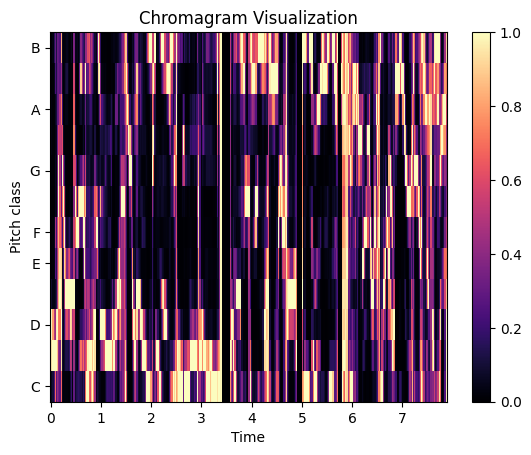

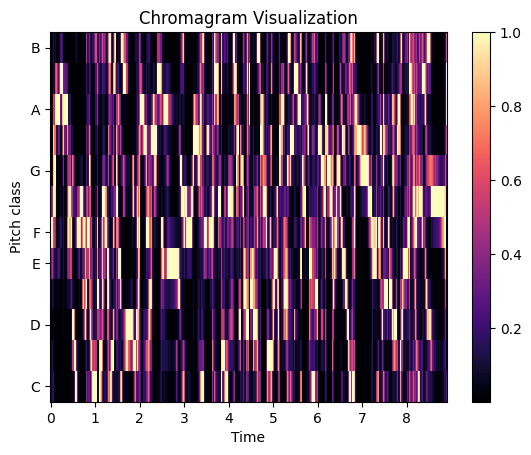

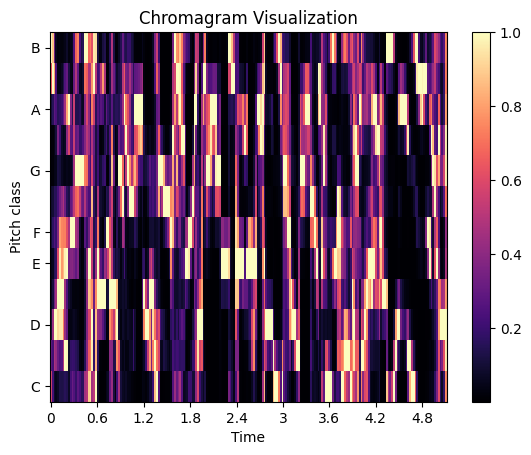

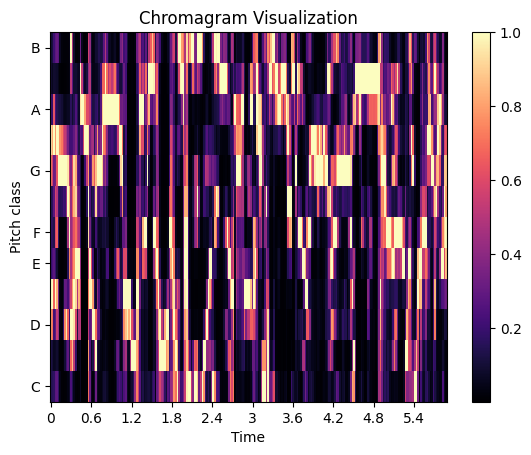

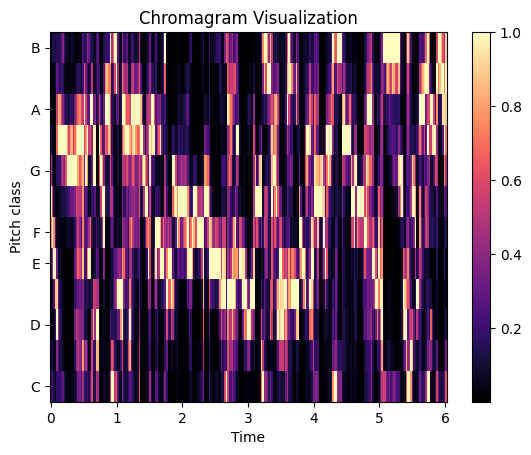

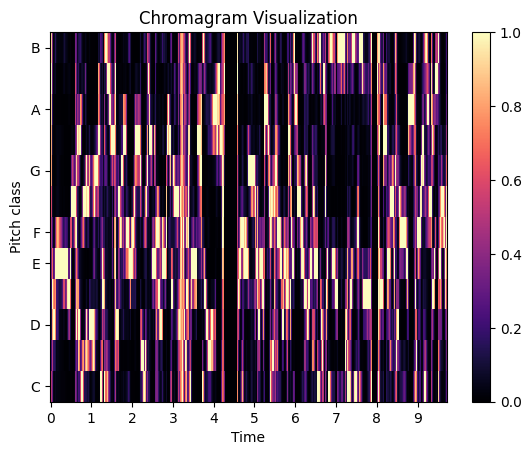

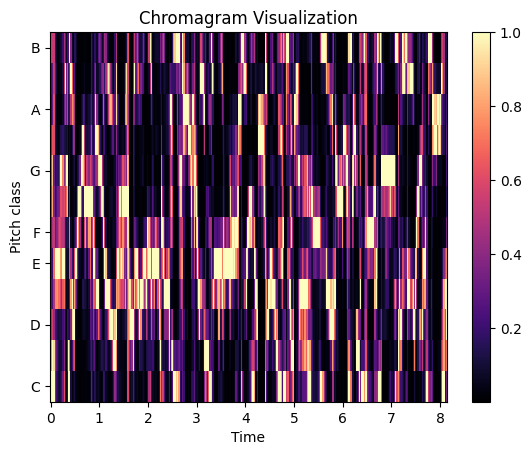

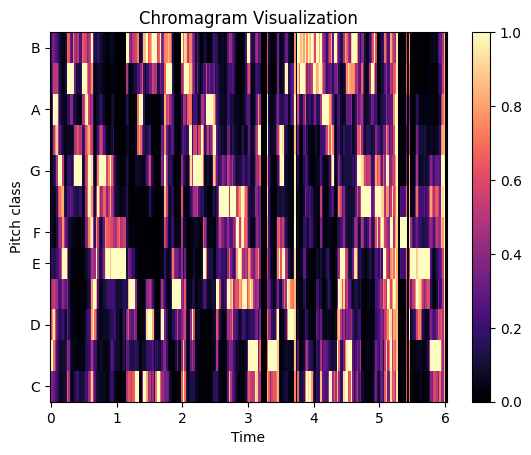

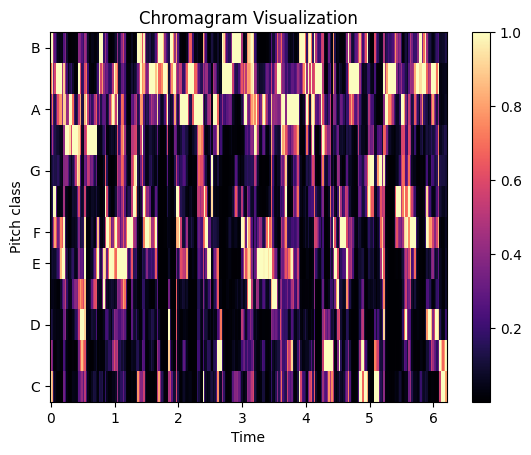

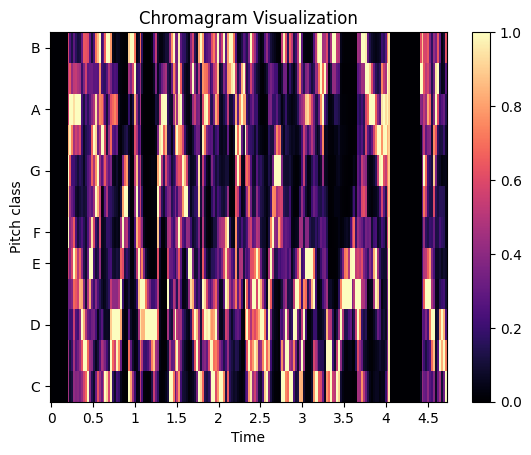

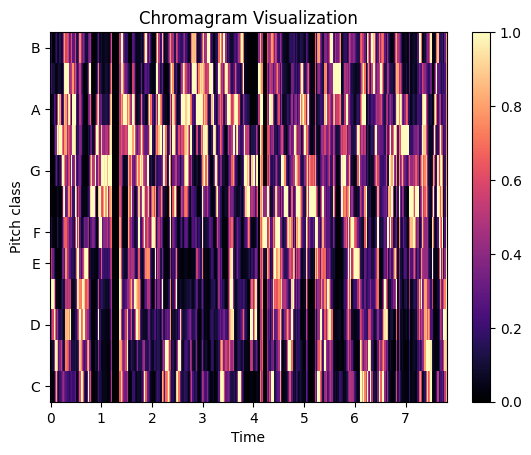

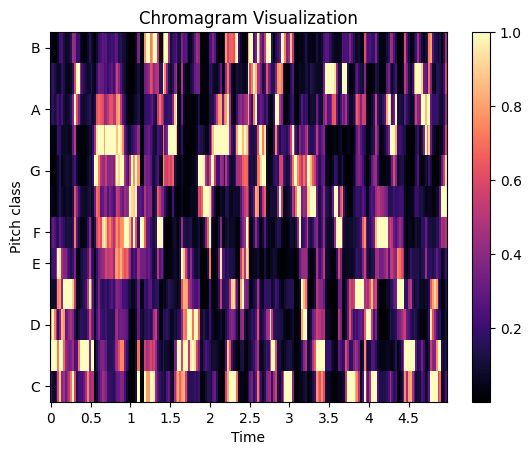

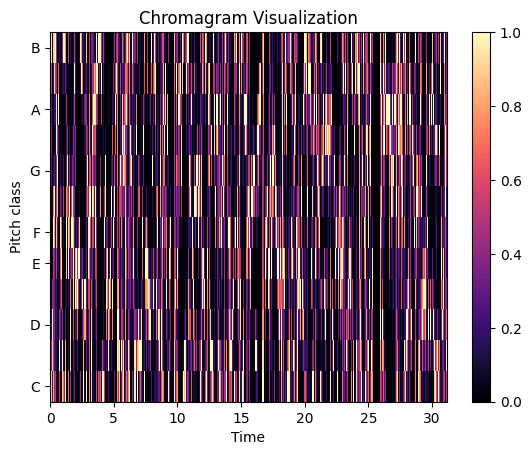

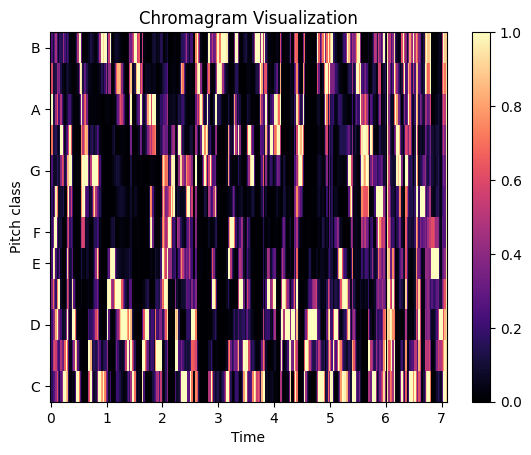

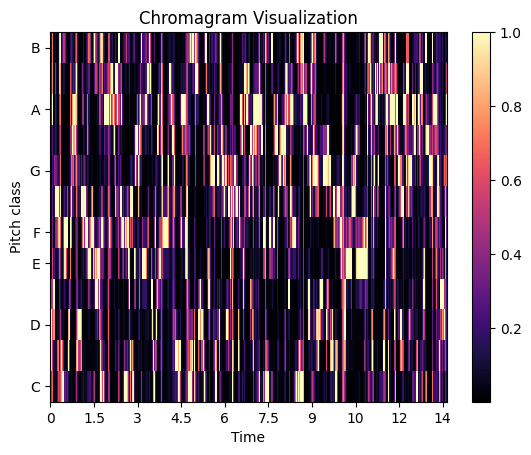

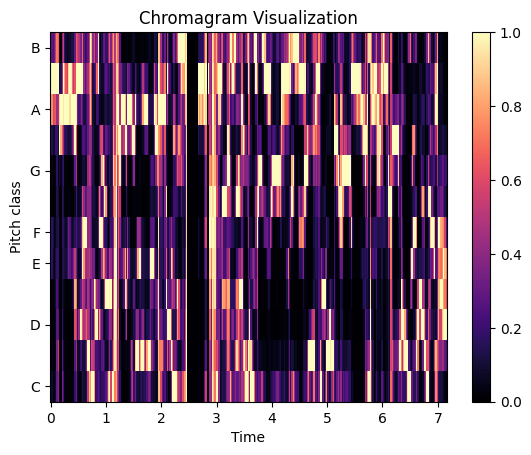

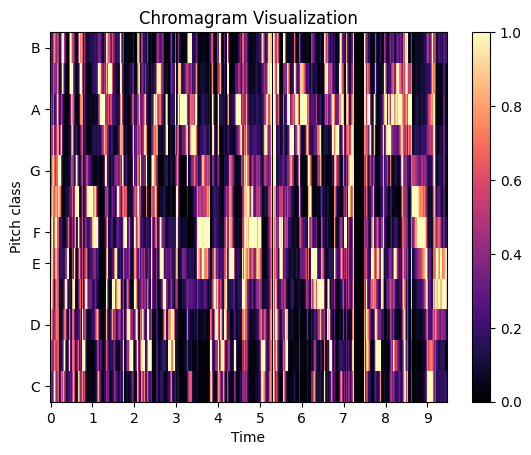

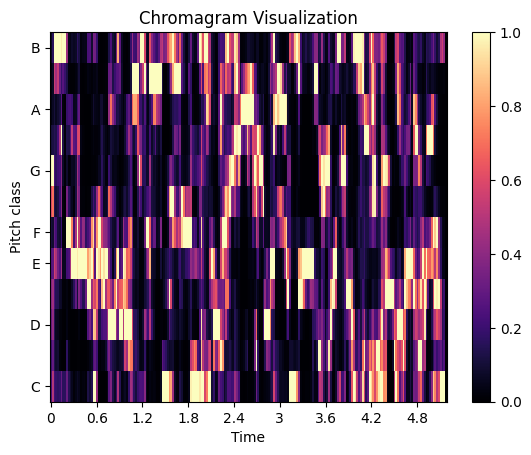

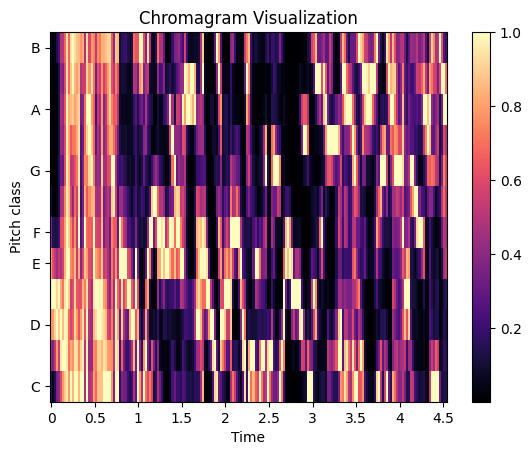

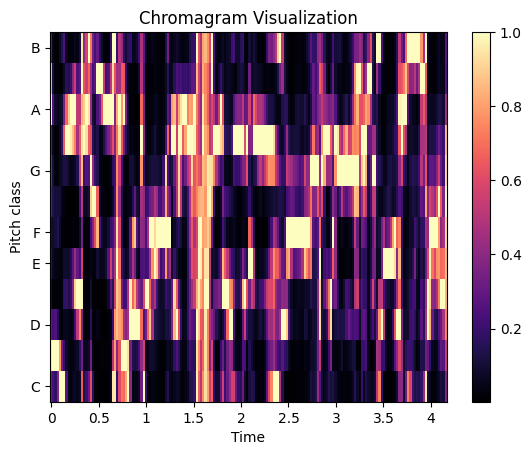

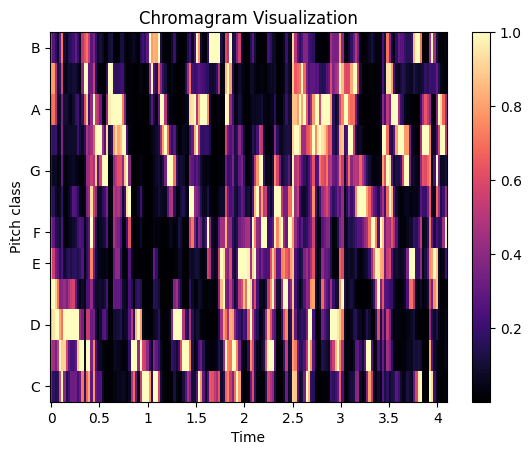

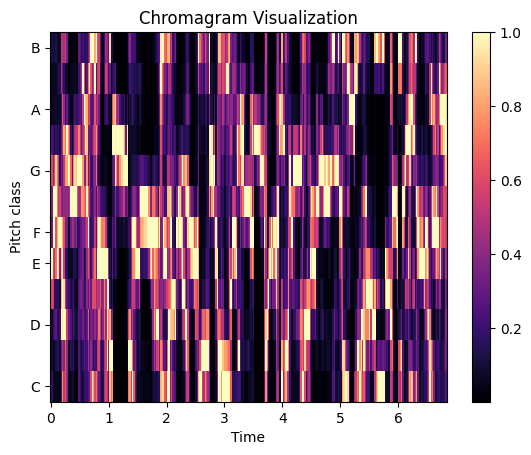

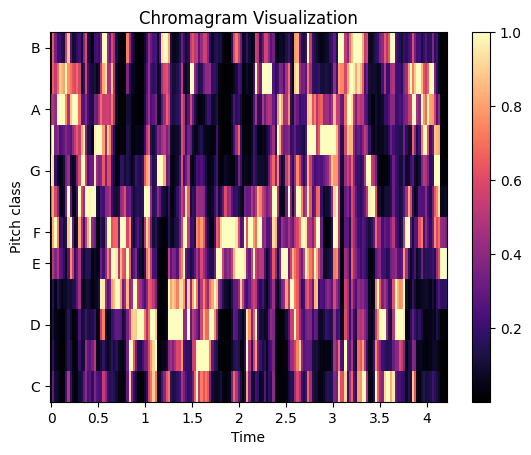

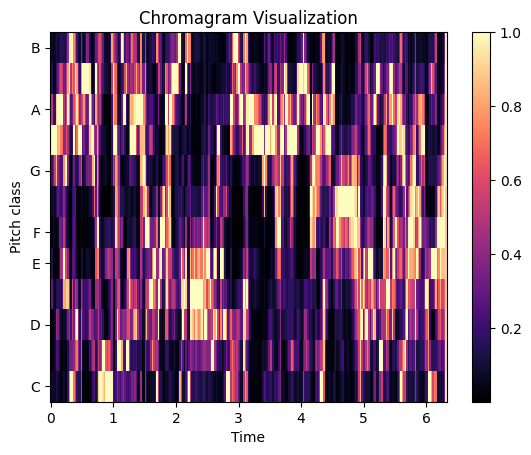

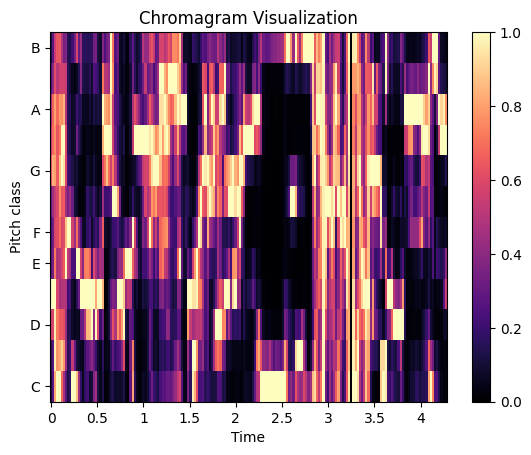

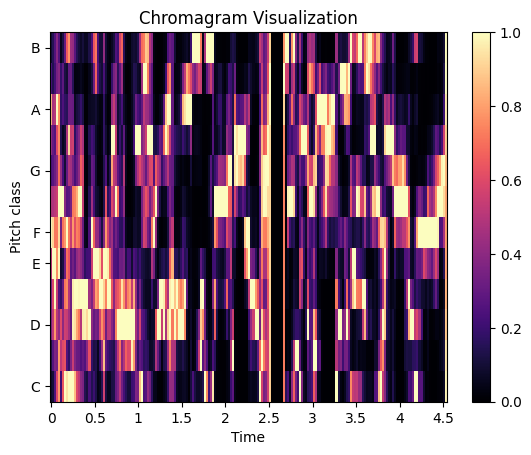

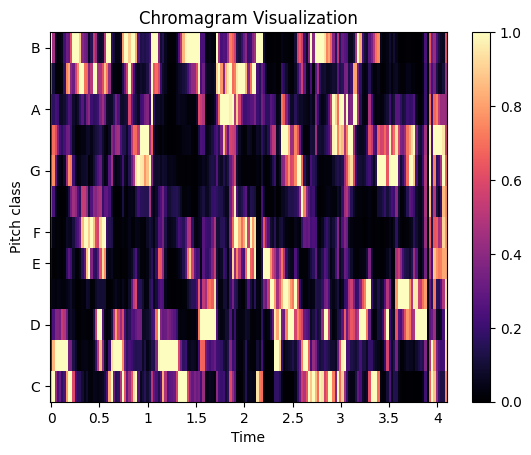

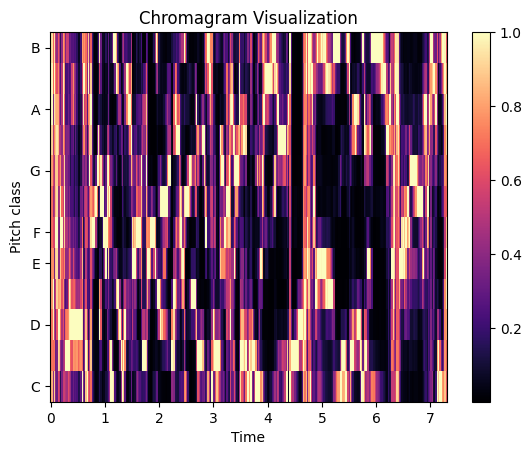

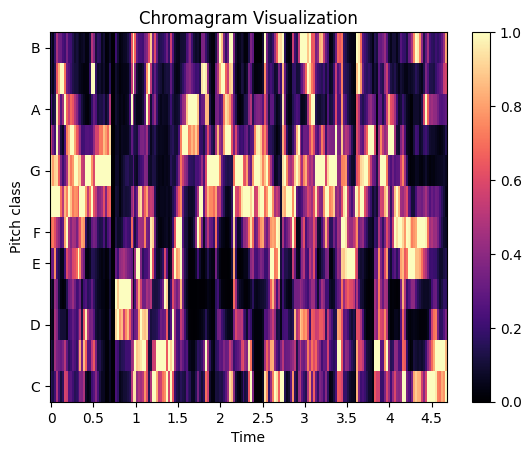

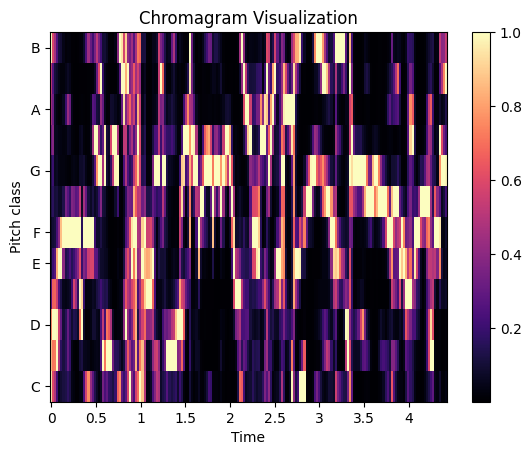

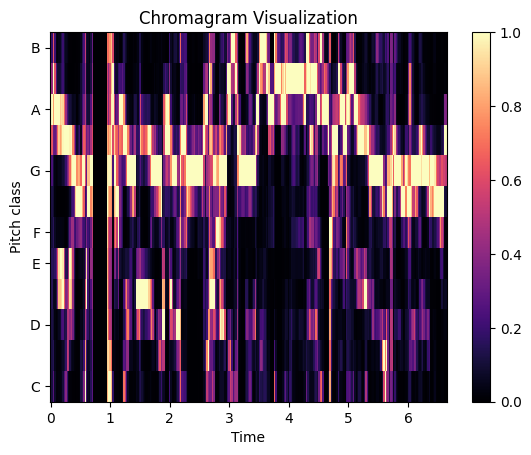

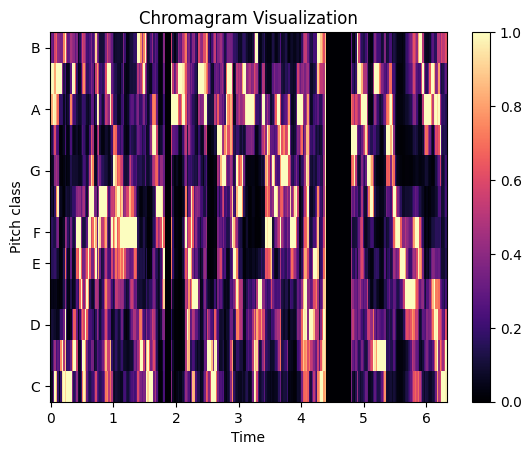

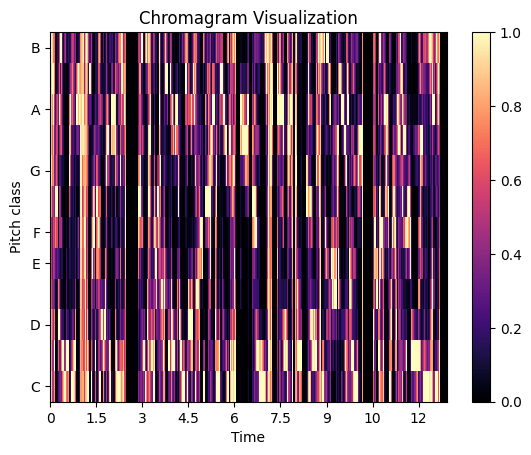

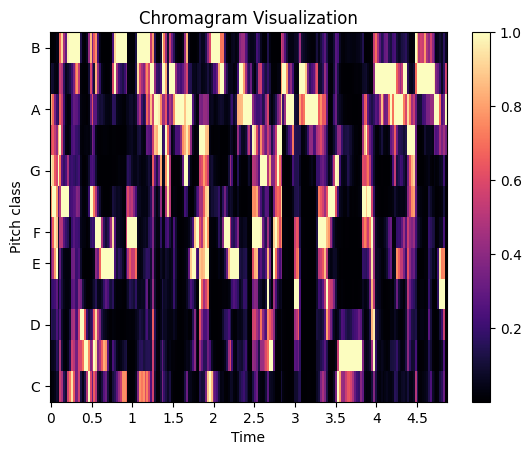

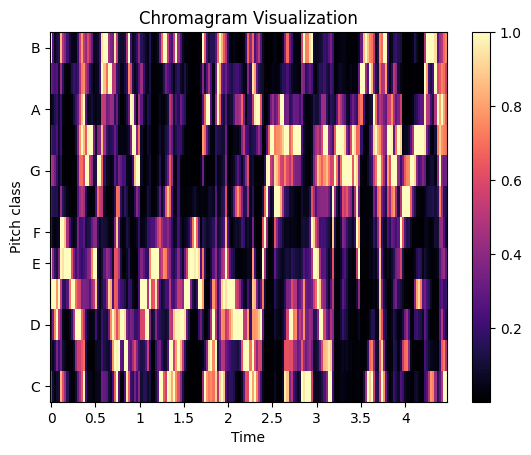

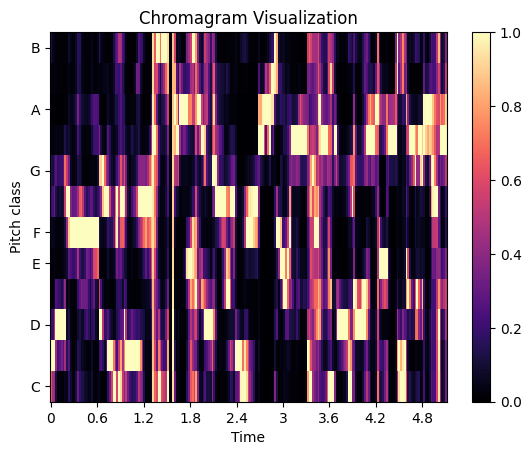

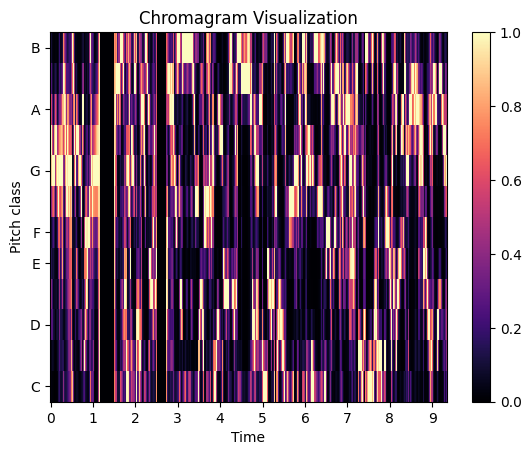

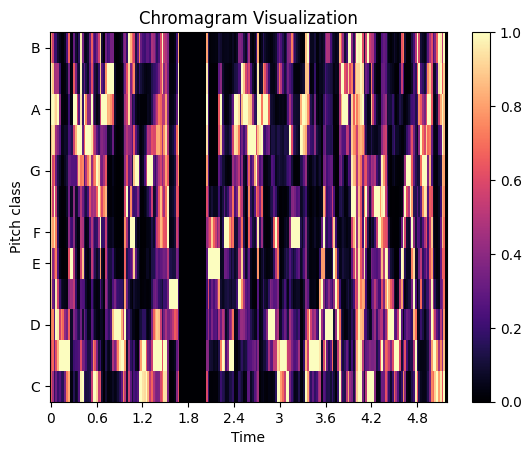

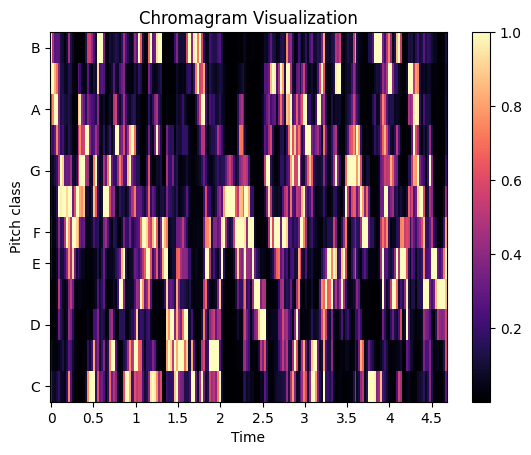

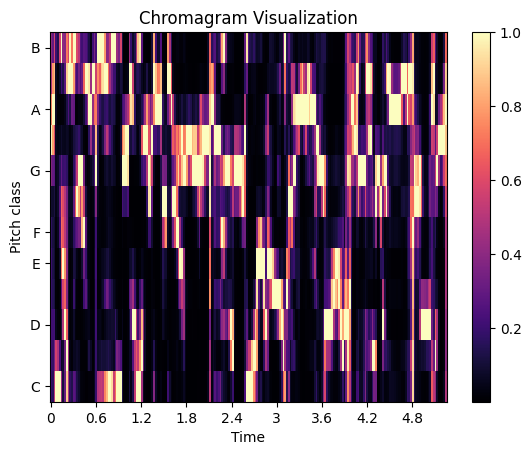

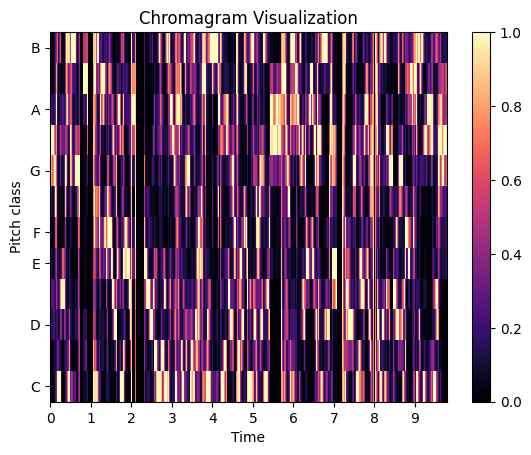

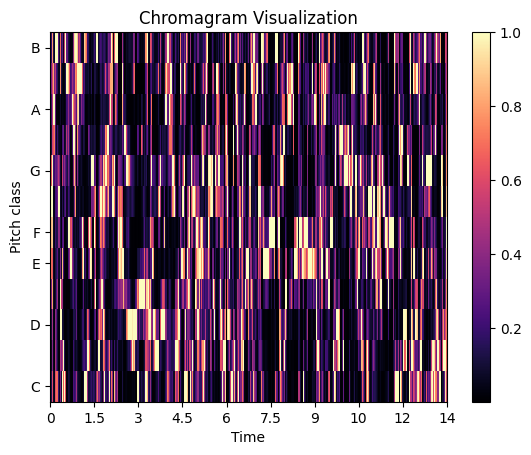

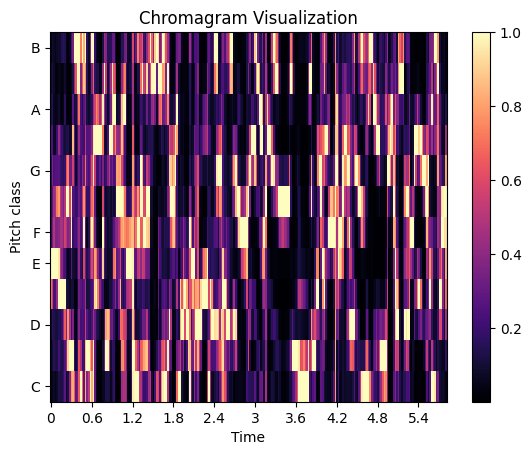

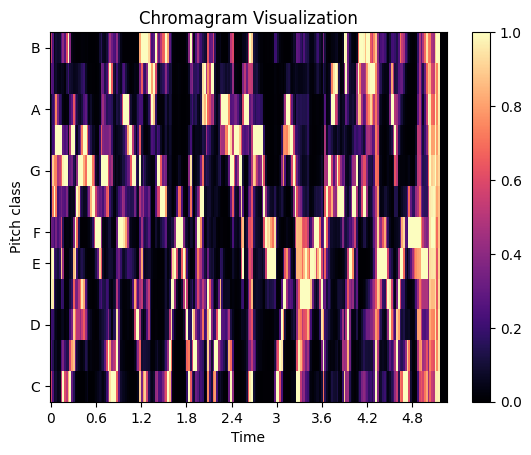

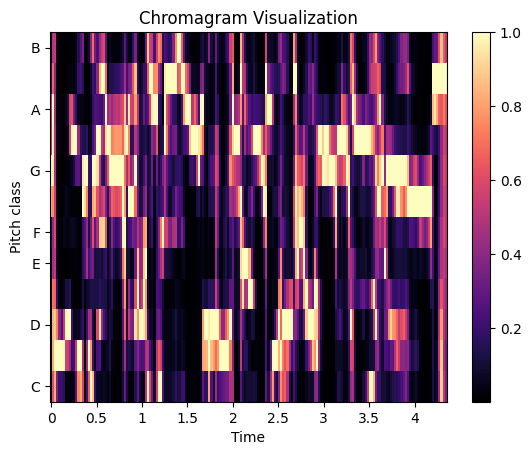

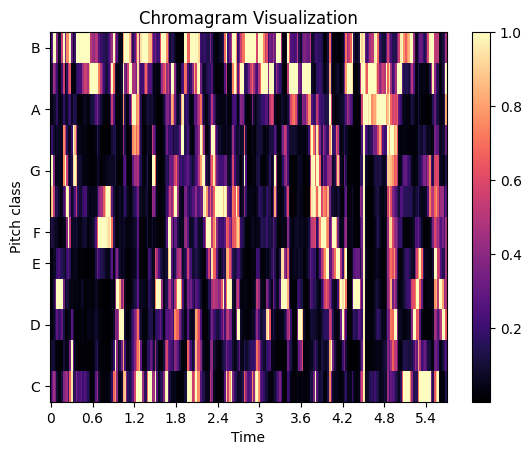

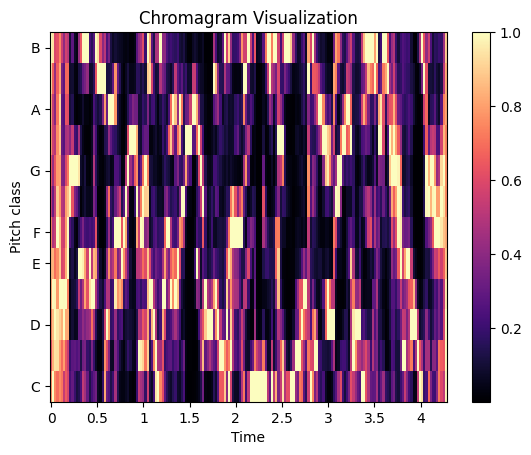

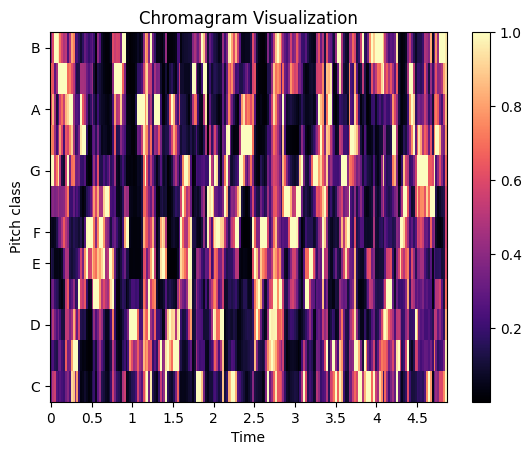

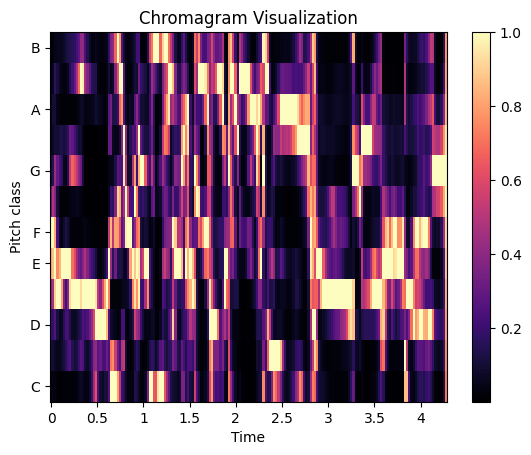

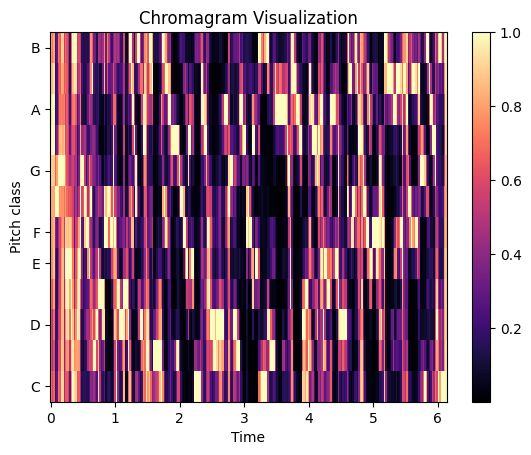

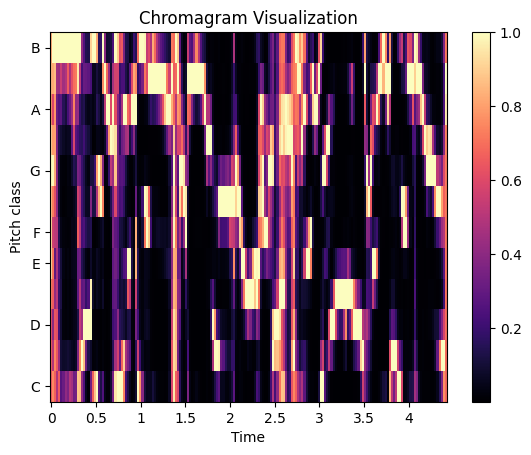

In [15]:
path_arr=(final_df.iloc[0:51,40:41]).to_numpy()
for file_path in path_arr:
    file_name=os.path.basename(file_path[0])
    audio_images_dir=main_dir+"\\VoxCeleb_gender\\audio_chromagrams\\"
    y, sr= librosa.load(file_path[0])
    y_chroma = librosa.feature.chroma_stft(y, sr=sr)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(y_chroma, y_axis = 'chroma', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title = 'Chromagram Visualization')
    plt.savefig(audio_images_dir+file_name.split(".")[0] + ".png")